# <font color=#025dfa> 3 Farklı Yolla Moda Öneri Sistemi ve Derin Öğrenme - Fashion Recommendation System and Deep Learning in 3 Different Ways

TR = Her yorum satırı kendisini üstündeki koda aittir. İlk olarak Türkçe, son olarak İngilizce yazıldı.

EN = Each comment line belongs to the code above it. It was first written in Turkish and lastly in English.

TR = Bu proje, moda ürünleri için kapsamlı bir öneri sistemi geliştirmeyi amaçlamaktadır. Moda öneri sistemi, popülerliğe dayalı yöntemler, kullanıcı tabanlı matris faktörizasyonu, K-en yakın komşular algoritması ve derin öğrenme yaklaşımlarını entegre ederek kullanıcılara kişiselleştirilmiş ve hassas öneriler sunacaktır. Proje, çeşitli öneri algoritmalarının birleşimi ile moda seçimlerini daha iyi tahmin etmeyi ve kullanıcı deneyimini geliştirmeyi hedeflemektedir, böylece moda perakendecilerinin müşteri memnuniyetini artırmalarına yardımcı olacaktır.

EN = This project aims to develop a comprehensive recommendation system for fashion products. The fashion recommendation system will provide personalized and precise recommendations to users by integrating popularity-based methods, user-based matrix factorization, K-nearest neighbors algorithm, and deep learning approaches. The project aims to better predict fashion choices and improve user experience through the combination of various recommendation algorithms, thus helping fashion retailers increase customer satisfaction.

Kaynak/Source = https://thecleverprogrammer.com/2023/06/05/hybrid-recommendation-system-using-python/

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import json
from scipy import spatial
import re
import warnings
warnings.filterwarnings('ignore')

from scipy import spatial #harital üzerindeki mesafeyi ölçüyor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization,Flatten, LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('fashion_products.csv')

In [3]:
df.head()

,User ID,Product ID,Product Name,Brand,Category,Price,Rating,Color,Size
0,19,1,Dress,Adidas,Men's Fashion,40,1.043159,Black,XL
1,97,2,Shoes,H&M,Women's Fashion,82,4.026416,Black,L
2,25,3,Dress,Adidas,Women's Fashion,44,3.337938,Yellow,XL
3,57,4,Shoes,Zara,Men's Fashion,23,1.049523,White,S
4,79,5,T-shirt,Adidas,Men's Fashion,79,4.302773,Black,M


In [4]:
df.columns = df.columns.str.replace(' ', '_')

In [5]:
df.head()

,User_ID,Product_ID,Product_Name,Brand,Category,Price,Rating,Color,Size
0,19,1,Dress,Adidas,Men's Fashion,40,1.043159,Black,XL
1,97,2,Shoes,H&M,Women's Fashion,82,4.026416,Black,L
2,25,3,Dress,Adidas,Women's Fashion,44,3.337938,Yellow,XL
3,57,4,Shoes,Zara,Men's Fashion,23,1.049523,White,S
4,79,5,T-shirt,Adidas,Men's Fashion,79,4.302773,Black,M


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   User_ID       1000 non-null   int64  
 1   Product_ID    1000 non-null   int64  
 2   Product_Name  1000 non-null   object 
 3   Brand         1000 non-null   object 
 4   Category      1000 non-null   object 
 5   Price         1000 non-null   int64  
 6   Rating        1000 non-null   float64
 7   Color         1000 non-null   object 
 8   Size          1000 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 70.4+ KB


In [7]:
df.iloc[586]

User_ID                      41
Product_ID                  587
Product_Name            T-shirt
Brand                    Adidas
Category        Women's Fashion
Price                        50
Rating                 1.252962
Color                      Blue
Size                         XL
Name: 586, dtype: object

In [8]:
df.Product_ID.value_counts()

Product_ID
1       1
672     1
659     1
660     1
661     1
       ..
339     1
340     1
341     1
342     1
1000    1
Name: count, Length: 1000, dtype: int64

In [9]:
df.User_ID.nunique()

100

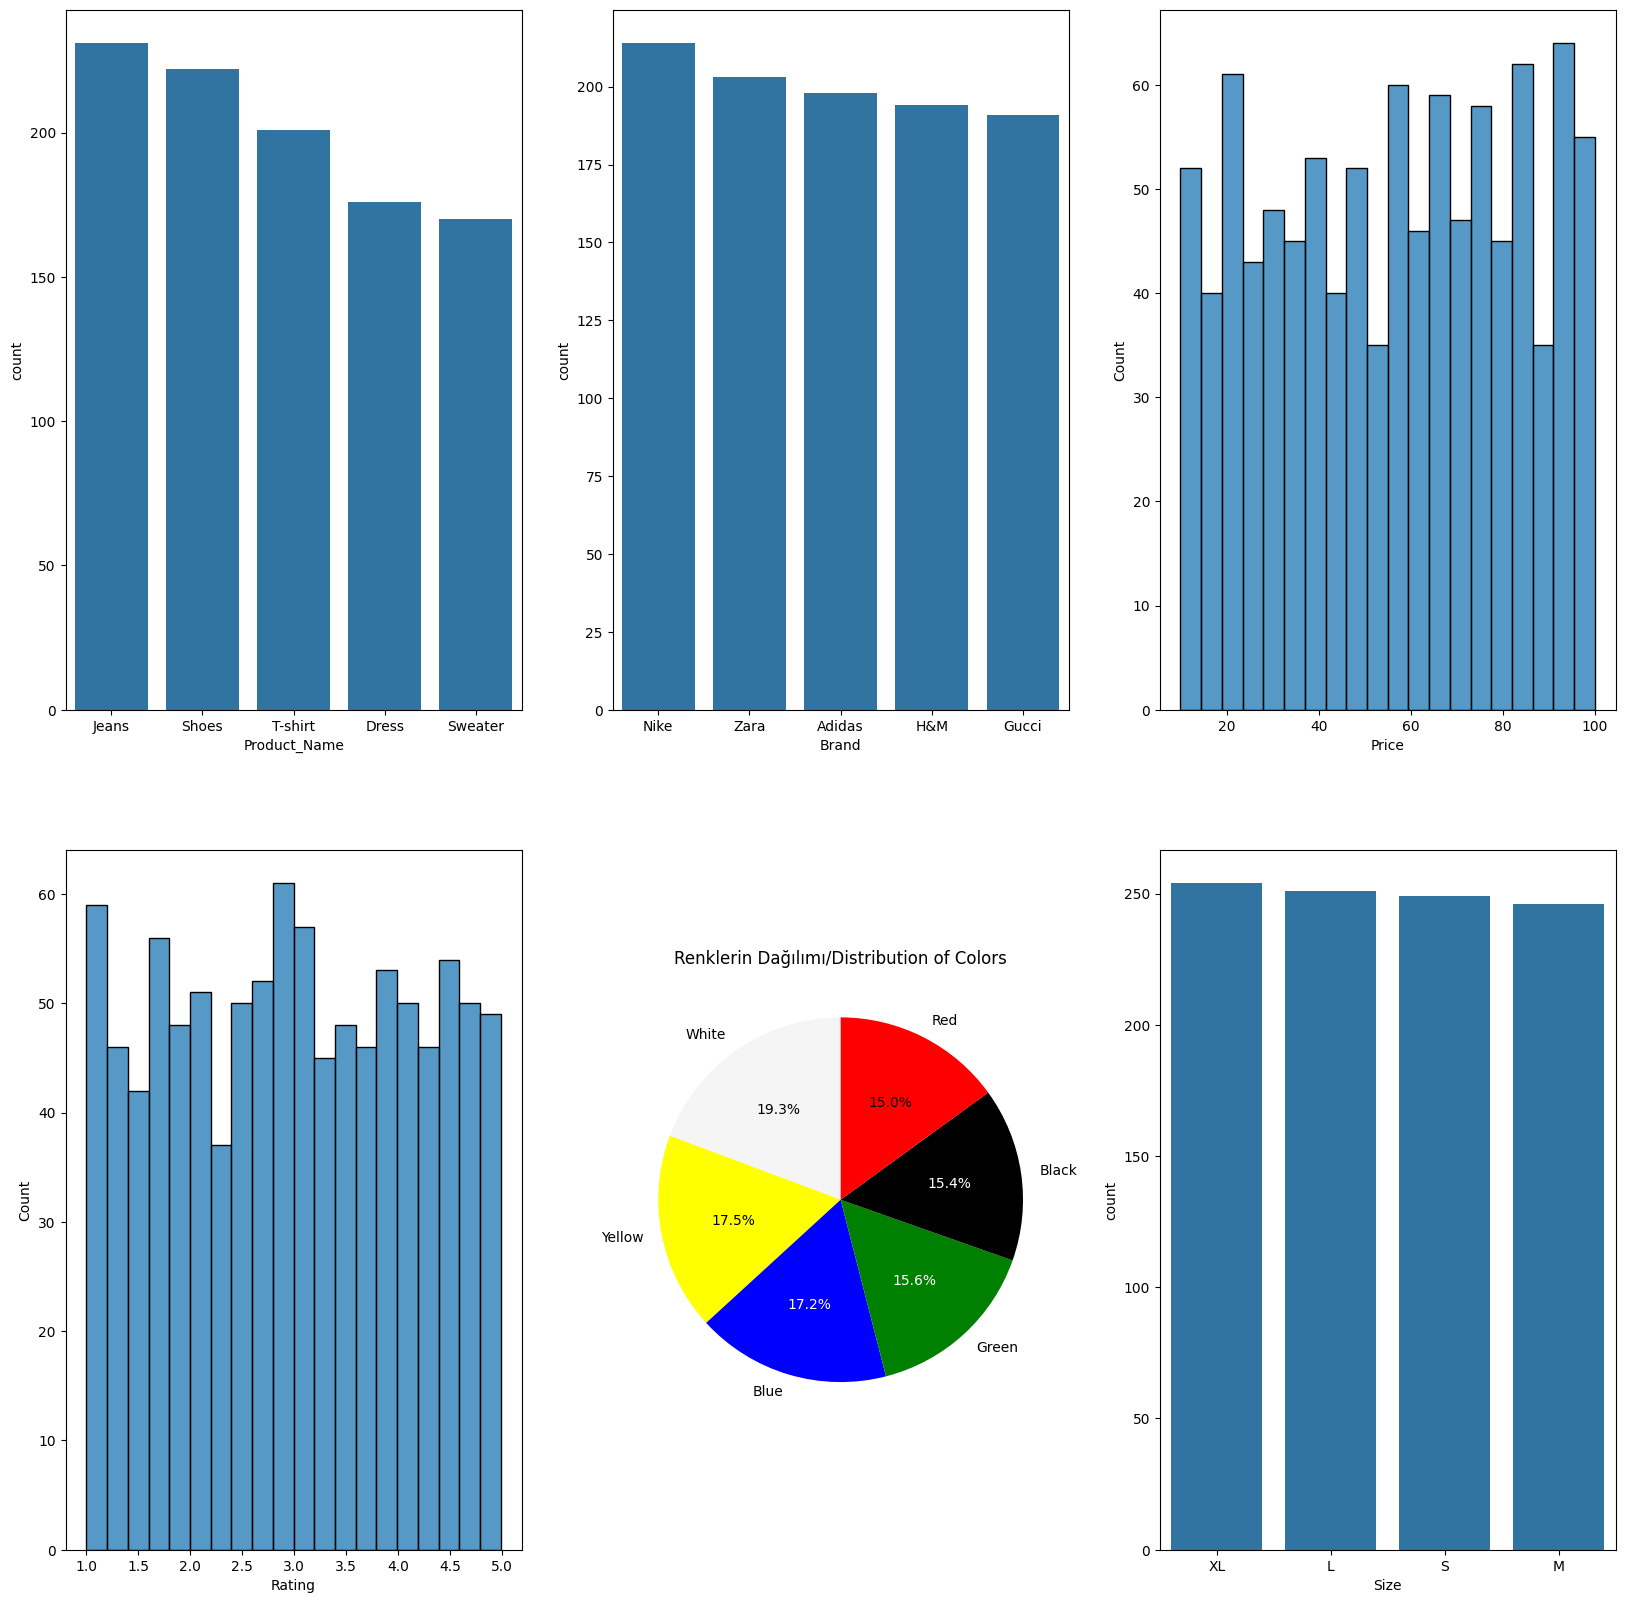

In [10]:
color_map = {
    'Red': 'red',
    'Black': 'black',
    'White': '#f5f5f5',
    'Yellow': 'yellow',
    'Blue': 'blue',
    'Green': 'green'
}

fig, ax2=plt.subplots(2,3,figsize=(20,20))
# TR = Subplot çoklu tablo oluşturuyor. a yerine kaç tane satır ve sütün olması gerektiğini yazacağız.
# EN = Subplot creates multiple tables. Instead of a, we will write how many rows and columns there should be


sns.countplot(x='Product_Name', data=df, order=df['Product_Name'].value_counts().index,ax=ax2[0][0])
sns.countplot(x='Brand', data=df, order=df['Brand'].value_counts().index, ax=ax2[0][1])  
# TR = 'Brand' sütunundaki her bir markanın frekansını gösteren bir histogram oluşturur  
# EN = Creates a count plot showing the frequency of each brand in the 'Brand' column

sns.histplot(x='Price', data=df, bins=20, ax=ax2[0][2])  
# TR = 'Price' sütunundaki fiyatların histogramını oluşturur, 20 bin kullanır  
# EN = Creates a histogram of prices in the 'Price' column with 20 bins

sns.histplot(x='Rating', data=df, bins=20,ax=ax2[1][0])

color_counts = df['Color'].value_counts()  
# TR = 'Color' sütunundaki renklerin her birinin frekansını hesaplar  
# EN = Counts the frequency of each color in the 'Color' column

colors = [color_map[color] for color in color_counts.index]  
# TR = Her renge karşılık gelen renk kodlarını color_map kullanarak belirler  
# EN = Determines the color codes for each color using the color_map

wedges, texts, autotexts = ax2[1][1].pie(color_counts, labels=color_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)  
# TR = Renklerin dağılımını gösteren bir pasta grafiği oluşturur, her dilimi etiketler ve renkler ile gösterir  
# EN = Creates a pie chart showing the distribution of colors, labels each slice, and colors it accordingly

highlight_colors = ['Black', 'Blue', 'Green']  
# TR = Öne çıkarılacak renklerin listesi  
# EN = List of colors to highlight

for i, wedge in enumerate(wedges):  
    if color_counts.index[i] in highlight_colors:  
        autotexts[i].set_color('white')  
# TR = Belirtilen renkler için pasta dilimlerinin üzerindeki yüzdeleri beyaz renkte gösterir  
# EN = Sets the percentage labels to white for the specified highlighted colors

ax2[1][1].set_title('Renklerin Dağılımı/Distribution of Colors')  
# TR = Pasta grafiğine başlık ekler  
# EN = Adds a title to the pie chart


sns.countplot(x='Size', data=df, order=df['Size'].value_counts().index,ax=ax2[1][2]);
# TR = ax2 sonrası ([x][y]) yazı [x] ekseninde kaçıncı sırada,[y] ekseninde kaçıncı sırada olacağını belirtiyor.
# EN = The text after ax2 ([x][y]) indicates the rank on the [x] axis and the rank on the [y] axis.

## <font color=#FFD700> Popülerliğe Dayalı - Popularity Based

In [11]:
df_grouped = df.groupby('Product_Name').agg({'Rating': [np.size, np.sum, np.mean]})
# TR = df veri setini 'Product_Name' sütununa göre gruplayıp, her ürün için 'fashion' sütununda 3 farklı istatistiği hesaplıyoruz:
#     np.size ile kaç değerlendirme yapıldığını (sayısı),
#     np.sum ile toplam değerlendirme puanını,
#     np.mean ile ortalama değerlendirme puanını hesaplıyoruz.

# EN = We are grouping the df dataset by the 'Product_Name' column, and calculating 3 different statistics for the 'fashion' column:
#     np.size to get the number of fashion (count),
#     np.sum to get the total rating score,
#     np.mean to get the average rating score.


In [12]:
df_grouped

Rating                      
               size         sum      mean
Product_Name                             
Dress           176  530.745724  3.015601
Jeans           231  687.030758  2.974159
Shoes           222  644.577195  2.903501
Sweater         170  536.864749  3.158028
T-shirt         201  593.916679  2.954809

In [13]:
populer_fashions = df_grouped.sort_values(('Rating', 'mean'), ascending=False)
# TR = df_grouped veri setini 'rating' sütununun 'mean' (ortalama) değerine göre azalan sırayla sıralıyoruz.
#     Bu, en yüksek ortalama puana sahip ürünleri en üste getirir.

# EN = We are sorting the df_grouped dataset by the 'mean' (average) value of the 'rating' column in descending order.
#     This brings the fashions with the highest average fashion to the top.


In [14]:
populer_fashions.head()

Rating                      
               size         sum      mean
Product_Name                             
Sweater         170  536.864749  3.158028
Dress           176  530.745724  3.015601
Jeans           231  687.030758  2.974159
T-shirt         201  593.916679  2.954809
Shoes           222  644.577195  2.903501

In [15]:
grouped_sum = df_grouped['Rating']['sum'].sum()
# TR = df_grouped veri setindeki 'rating' sütununun 'sum' (toplam) değerlerini topluyoruz.
#     Bu, tüm ürünler için toplam değerlendirme puanlarını toplar.

# EN = We are summing the 'sum' values from the 'rating' column in the df_grouped dataset.
#     This gives the total rating score across all fashions.

In [16]:
populer_fashions['percentage'] = df_grouped['Rating']['sum'].div(grouped_sum) * 100
# TR = df_grouped veri setindeki her bir kitabın 'rating' sütunundaki 'sum' (toplam) değerini, grouped_sum (tüm ürünlerin toplam değerlendirme puanı) ile bölüyoruz.
#     Sonucu 100 ile çarparak, her kitabın toplam değerlendirme puanının tüm ürünlerin arasındaki yüzdesini hesaplıyoruz.

# EN = We are dividing the 'sum' (total) value from the 'rating' column in the df_grouped dataset by grouped_sum (the total rating score for all fashions).
#     We multiply the result by 100 to calculate the percentage of each fashion's total rating score relative to the total across all fashions.


In [17]:
populer_fashions.head()

Rating                       percentage
               size         sum      mean           
Product_Name                                        
Sweater         170  536.864749  3.158028  17.936536
Dress           176  530.745724  3.015601  17.732100
Jeans           231  687.030758  2.974159  22.953550
T-shirt         201  593.916679  2.954809  19.842628
Shoes           222  644.577195  2.903501  21.535185

In [18]:
populer_fashions = populer_fashions.sort_values('percentage', ascending=False)
# TR = populer_books veri setini 'percentage' sütununa göre azalan sırayla sıralıyoruz.
#     Bu, en yüksek yüzdelik değere sahip kitapları en üste getirir.
# EN = We are sorting the populer_books dataset by the 'percentage' column in descending order.
#     This brings the books with the highest percentage values to the top.

In [19]:
populer_fashions

Rating                       percentage
               size         sum      mean           
Product_Name                                        
Jeans           231  687.030758  2.974159  22.953550
Shoes           222  644.577195  2.903501  21.535185
T-shirt         201  593.916679  2.954809  19.842628
Sweater         170  536.864749  3.158028  17.936536
Dress           176  530.745724  3.015601  17.732100

In [20]:
populer_fashions['Rank'] = populer_fashions['percentage'].rank(ascending=False)
# TR = populer_books veri setindeki 'percentage' sütununa göre her kitapı bir sıralama (rank) numarası veriyoruz.
#     Bu sıralama, yüzdelik değerlere göre azalan sırayla yapılır, yani en yüksek yüzdelik değere sahip kitap birinci sıradadır.

# EN = We are assigning a rank to each book in the populer_books dataset based on the 'percentage' column.
#     The ranking is done in descending order, meaning the book with the highest percentage gets the top rank.

In [21]:
populer_fashions.head()

Rating                       percentage Rank
               size         sum      mean                
Product_Name                                             
Jeans           231  687.030758  2.974159  22.953550  1.0
Shoes           222  644.577195  2.903501  21.535185  2.0
T-shirt         201  593.916679  2.954809  19.842628  3.0
Sweater         170  536.864749  3.158028  17.936536  4.0
Dress           176  530.745724  3.015601  17.732100  5.0

## <font color=#C0C0C0> Kullanıcı Tabanlı Matris Faktörizasyonu - User Based Matrix Factorization

In [22]:
df.head()

,User_ID,Product_ID,Product_Name,Brand,Category,Price,Rating,Color,Size
0,19,1,Dress,Adidas,Men's Fashion,40,1.043159,Black,XL
1,97,2,Shoes,H&M,Women's Fashion,82,4.026416,Black,L
2,25,3,Dress,Adidas,Women's Fashion,44,3.337938,Yellow,XL
3,57,4,Shoes,Zara,Men's Fashion,23,1.049523,White,S
4,79,5,T-shirt,Adidas,Men's Fashion,79,4.302773,Black,M


In [23]:
fashion_ratings = df.pivot_table(index=['User_ID'], columns=['Product_Name'], values='Rating')
# TR = ratings veri setini kullanarak bir pivot tablo oluşturuyoruz.
#     Bu tablo, her kullanıcı (ISBN) için her kitap (bookTitle) için değerlendirme (rating) değerlerini içerir.
#     Kullanıcılar satırlarda, kitaplar sütunlarda yer alır ve her hücrede kullanıcı tarafından verilen değerlendirme puanı bulunur.
# EN = We are creating a pivot table from the ratings dataset.
#     The table contains rating values for each user (ISBN) and each book (bookTitle).
#     Users are in rows, books are in columns, and each cell contains the rating given by the user to the book.


In [24]:
fashion_ratings

Product_Name,Dress,Jeans,Shoes,Sweater,T-shirt
User_ID,,,,,
1,4.145369,NaN,3.103106,2.041341,2.886467
2,NaN,3.099777,1.975304,4.480169,1.270583
3,4.818010,3.045753,2.731678,4.136797,2.462684
4,3.104640,3.349588,2.012338,3.276222,2.918078
5,3.529656,3.472511,3.148710,NaN,NaN
...,...,...,...,...,...
96,4.639821,2.129789,4.592906,4.466182,NaN
97,NaN,NaN,2.711527,3.493859,2.386739
98,2.595124,2.782557,3.242832,NaN,2.828291


In [25]:
df.head()

,User_ID,Product_ID,Product_Name,Brand,Category,Price,Rating,Color,Size
0,19,1,Dress,Adidas,Men's Fashion,40,1.043159,Black,XL
1,97,2,Shoes,H&M,Women's Fashion,82,4.026416,Black,L
2,25,3,Dress,Adidas,Women's Fashion,44,3.337938,Yellow,XL
3,57,4,Shoes,Zara,Men's Fashion,23,1.049523,White,S
4,79,5,T-shirt,Adidas,Men's Fashion,79,4.302773,Black,M


In [26]:
fashion_ratings['Dress']

User_ID
1      4.145369
2           NaN
3      4.818010
4      3.104640
5      3.529656
         ...   
96     4.639821
97          NaN
98     2.595124
99          NaN
100    4.310893
Name: Dress, Length: 100, dtype: float64

In [27]:
Dress_ratings=fashion_ratings['Dress']

In [28]:
Dress_ratings.value_counts()

Dress
4.145369    1
3.755338    1
2.977355    1
2.391692    1
4.293928    1
           ..
2.890065    1
4.118362    1
4.154889    1
1.820456    1
4.310893    1
Name: count, Length: 79, dtype: int64

In [29]:
fashion_ratings[['Dress', 'Shoes']].corr()
# TR = book_ratings veri setindeki aynı kitap için iki sütunu seçiyoruz ('Classical Mythology' burada iki kez geçiyor).
#     Daha sonra bu iki sütun arasındaki korelasyonu hesaplıyoruz.
#     Sonuç, aynı kitabın iki kez yer alması nedeniyle her iki sütun arasında mükemmel bir korelasyon gösterir (korelasyon katsayısı 1 olur).
# EN = We are selecting two columns for the same book ('Classical Mythology' appears twice) from the book_ratings dataset.
#     Then we calculate the correlation between these two columns.
#     The result will show a perfect correlation (correlation coefficient of 1) since both columns refer to the same book.


Product_Name,Dress,Shoes
Product_Name,,
Dress,1.000000,-0.029487
Shoes,-0.029487,1.000000


In [30]:
fashion_ratings.corrwith(Dress_ratings)
# TR = book_ratings veri setindeki kitaplar ile Classical_Mythology_ratings veri setindeki kitaplar arasındaki korelasyonu hesaplıyoruz.
#     Bu, her bir kitabın 'Classical_Mythology_ratings' ile olan benzerliğini ölçer ve 'Classical_Mythology_ratings' ile en yüksek korelasyona sahip kitapları belirler.
# EN = We are calculating the correlation between the book in the book_ratings dataset and the books in the Classical_Mythology_ratings dataset.
#     This measures the similarity of each book to 'Classical_Mythology_ratings' and identifies books that have the highest correlation with 'Classical_Mythology_Ump_ratings'.

Product_Name
Dress      1.000000
Jeans     -0.092151
Shoes     -0.029487
Sweater    0.178173
T-shirt    0.168612
dtype: float64

In [31]:
#similar_books benzer kitaplar demek
similar_fashions = fashion_ratings.corrwith(Dress_ratings)
# TR = book_ratings veri setindeki kitaplarda Classical_Mythology_ratings veri setindeki kitaplar arasındaki korelasyonu hesaplıyoruz.
#     Bu, her bir kitabın 'Classical_Mythology_ratings' ile olan benzerliğini ölçer ve 'Classical_Mythology_ratings' ile benzerlik gösteren kitapları belirler.
# EN = We are calculating the correlation between the books in the book_ratings dataset and the books in the Classical_Mythology_ratings dataset.
#     This measures the similarity of each book to 'Classical_Mythology_ratings' and identifies books that are similar to 'Classical_Mythology_ratings'.

In [32]:
similar_fashions = similar_fashions.dropna()
# TR = similar_books veri setindeki eksik (NaN) değerleri temizliyoruz.
#     Bu işlem, eksik değerler içeren satırları veri setinden çıkarır ve yalnızca geçerli korelasyon değerlerine sahip ürünleri bırakır.
# EN = We are removing missing (NaN) values from the similar_books dataset.
#     This operation removes rows with missing values and keeps only the rows with valid correlation values.

In [33]:
similar_fashions.sort_values(ascending=False)

Product_Name
Dress      1.000000
Sweater    0.178173
T-shirt    0.168612
Shoes     -0.029487
Jeans     -0.092151
dtype: float64

In [34]:
fashion_stats = df.groupby('Product_Name').agg({'Rating': [np.size, np.mean]})
# TR = ratings veri setini 'bookTitle' sütununa göre gruplayıp, her kitap için 'rating' sütununda iki istatistiği hesaplıyoruz:
#     np.size ile kitap başına kaç değerlendirme yapıldığını (sayısı) ve
#     np.mean ile kitap başına ortalama değerlendirme puanını hesaplıyoruz.
# EN = We are grouping the ratings dataset by the 'bookTitle' column and calculating two statistics for the 'rating' column for each book:
#     np.size to get the number of ratings per book (count), and
#     np.mean to get the average rating per book.

In [35]:
fashion_stats.head()

Rating          
               size      mean
Product_Name                 
Dress           176  3.015601
Jeans           231  2.974159
Shoes           222  2.903501
Sweater         170  3.158028
T-shirt         201  2.954809

In [36]:
populer_fashions = fashion_stats[fashion_stats['Rating']['size'] > 100]
# TR = book_stats veri setinde, 'rating' sütununda 100'den fazla değerlendirme almış olan kitapları seçiyoruz.
#     Bu, yalnızca en az 100 yorum veya değerlendirme almış kitapları içerir ve bunları popüler kitaplar olarak kabul ederiz.
# EN = We are selecting books from the book_stats dataset that have more than 100 ratings.
#     This includes only books that have received at least 100 ratings or reviews, considering them as popular books.


In [37]:
populer_fashions = populer_fashions.sort_values(('Rating', 'mean'), ascending=False)
# TR = populer_books veri setini 'rating' sütununun 'mean' (ortalama) değerine göre azalan sırayla sıralıyoruz.
#     Bu, en yüksek ortalama değerlendirme puanına sahip popüler kitapları en üste getirir.
# EN = We are sorting the populer_books dataset by the 'mean' (average) value of the 'rating' column in descending order.
#     This brings the popular books with the highest average ratings to the top.

In [38]:
populer_fashions.columns = populer_fashions.columns.get_level_values(0)
# TR = populer_books veri setindeki çok seviyeli (multi-level) sütun isimlerini tek seviyeli hale getiriyoruz.
#     Bu, sütun isimlerinin sadece ilk seviyesini kullanarak düz bir liste elde etmemizi sağlar.
# EN = We are flattening the multi-level column names in the populer_books dataset to a single level.
#     This simplifies the column names by keeping only the first level, resulting in a flat list of column names.

similar_fashions.name = 'similarity'
# TR = similar_books serisinin ismini 'similarity' olarak değiştiriyoruz.
#     Bu, benzerlik değerlerini temsil eden serinin adını belirler.
# EN = We are renaming the similar_books series to 'similarity'.
#     This assigns the name 'similarity' to the series representing the similarity values.

df2 = populer_fashions.join(similar_fashions)
# TR = populer_books veri setine similar_books serisini birleştiriyoruz.
#     Bu işlem, her popüler kitaba karşılık gelen benzerlik değerlerini içeren yeni bir veri seti oluşturur.
# EN = We are joining the similar_books series with the populer_books dataset.
#     This creates a new dataset that includes the similarity values corresponding to each popular book.


In [39]:
df2.head()

,Rating,Rating,similarity
Product_Name,,,
Sweater,170,3.158028,0.178173
Dress,176,3.015601,1.000000
Jeans,231,2.974159,-0.092151
T-shirt,201,2.954809,0.168612
Shoes,222,2.903501,-0.029487


In [40]:
df2.sort_values(['similarity'],ascending=False)

,Rating,Rating,similarity
Product_Name,,,
Dress,176,3.015601,1.000000
Sweater,170,3.158028,0.178173
T-shirt,201,2.954809,0.168612
Shoes,222,2.903501,-0.029487
Jeans,231,2.974159,-0.092151


## <font color=#1cfc03> K_En Yakın Komşular - KNN - K_Nearrest Neighboors

In [41]:
encoder = OneHotEncoder()
categories_encoded = encoder.fit_transform(df[['Category']]).toarray()

df['Category'] = list(categories_encoded)

In [42]:
fashion_properties = df.groupby('Product_ID').agg({'Rating': [np.size, np.mean]})
# TR = ratings veri setini 'ISBN' sütununa göre gruplayıp, her kitap için 'rating' sütununda iki istatistiği hesaplıyoruz:
#     np.size ile her litab için kaç değerlendirme yapıldığını (sayısı) ve
#     np.mean ile her kitab için ortalama değerlendirme puanını hesaplıyoruz.
# EN = We are grouping the ratings dataset by the 'ISBN' column and calculating two statistics for the 'rating' column for each book:
#     np.size to get the number of ratings per book (count), and
#     np.mean to get the average rating per book.

In [43]:
fashion_properties

Rating          
             size      mean
Product_ID                 
1               1  1.043159
2               1  4.026416
3               1  3.337938
4               1  1.049523
5               1  4.302773
...           ...       ...
996             1  1.620081
997             1  1.544464
998             1  3.961913
999             1  3.089722
1000            1  3.093553

[1000 rows x 2 columns]

In [44]:
fashion_dict = {}
for _, row in df.iterrows():
    Product_ID = int(row['Product_ID'])
    # TR = Ürün ID'sini alıyoruz.
    # EN = We are extracting the product ID.

    name = row['Product_Name']
    # TR = Ürün ismini alıyoruz.
    # EN = We are extracting the product name.

    genres = row['Category']
    # TR = Ürünün kategorisini alıyoruz.
    # EN = We are extracting the category of the product.

    fashion_dict[Product_ID] = (name, genres.flatten(), row['Rating'], row['Size'])
    # TR = Ürün ID'sine karşılık gelen ürün bilgilerini dictionary'ye ekliyoruz:
    #     (ürün adı, kategori, değerlendirme puanı, beden)
    # EN = Adding product information to the dictionary for Product ID:
    #     (product name, category, rating, size)


In [45]:
genres

array([0., 0., 1.])

In [46]:
fashion_dict

{1: ('Dress', array([0., 1., 0.]), 1.0431592108361825, 'XL'),
 2: ('Shoes', array([0., 0., 1.]), 4.026416271141911, 'L'),
 3: ('Dress', array([0., 0., 1.]), 3.337937559377053, 'XL'),
 4: ('Shoes', array([0., 1., 0.]), 1.0495229563128543, 'S'),
 5: ('T-shirt', array([0., 1., 0.]), 4.302773408398684, 'M'),
 6: ('Dress', array([0., 1., 0.]), 1.3795657395330458, 'L'),
 7: ('Jeans', array([0., 1., 0.]), 1.3567503746842564, 'XL'),
 8: ('Sweater', array([1., 0., 0.]), 4.36030328941572, 'XL'),
 9: ('Sweater', array([0., 1., 0.]), 4.466181876278437, 'XL'),
 10: ('T-shirt', array([1., 0., 0.]), 4.093234402033421, 'XL'),
 11: ('T-shirt', array([0., 1., 0.]), 1.1609879573062742, 'S'),
 12: ('Sweater', array([1., 0., 0.]), 2.699735537578599, 'M'),
 13: ('Jeans', array([1., 0., 0.]), 1.6011935800534172, 'M'),
 14: ('Dress', array([0., 0., 1.]), 2.921004203947349, 'L'),
 15: ('Shoes', array([0., 1., 0.]), 3.670412239336502, 'M'),
 16: ('Dress', array([0., 0., 1.]), 1.4227161428043575, 'S'),
 17: ('Dr

In [47]:
def compute_distance(a, b):
    # TR = a ve b arasında mesafe hesaplayan bir fonksiyon. a ve b iki kitap temsil eden tuple'lardır.
    #     Bu fonksiyon, kitaplar arasındaki mesafeyi türler (genre) ve popülerlik (popularity) açısından hesaplar.

    genre_distance = spatial.distance.cosine(a[1], b[1])
    # TR = a ve b kitapların türleri arasındaki kosinüs mesafesini hesaplarız.
    #     a'nın ve b'nin tür vektörleri arasındaki kosinüs mesafesini kullanarak türler arasındaki benzerliği ölçeriz.
    # EN = We calculate the cosine distance between the genre vectors of books a and b.
    #     This measures the similarity between the genre vectors of the two books.

    popularity_distance = abs(a[2] - b[2])
    # TR = a ve b kitapların popülerlik (değerlendirme sayısı) arasındaki mutlak farkı hesaplarız.
    #     Bu, ürünlerler arasındaki popülerlik farkını ölçer.
    # EN = We calculate the absolute difference in popularity (number of ratings) between books a and b.
    #     This measures the difference in popularity between the two books.

    return genre_distance + popularity_distance
    # TR = Türler arasındaki mesafe ve popülerlik arasındaki farkı toplarız.
    # EN = We sum the genre distance and the popularity distance.


In [48]:
fashion_dict[2]

('Shoes', array([0., 0., 1.]), 4.026416271141911, 'L')

In [49]:
fashion_dict[4]

('Shoes', array([0., 1., 0.]), 1.0495229563128543, 'S')

In [50]:
distance = compute_distance(fashion_dict[2], fashion_dict[4])
# TR = book_dict sözlüğündeki ID'si 2 olan kitap ile ID'si 4 olan kitap arasındaki mesafeyi hesaplıyoruz.
#     Bu, iki kitap arasındaki türler ve popülerlik açısından mesafeyi belirler.
# EN = We are calculating the distance between the book with ID 2 and the book with ID 4 from the book_dict dictionary.
#     This measures the distance between the two books in terms of genre and popularity.

In [51]:
mesafeler = []
for fashion1 in fashion_dict:
    for fashion2 in fashion_dict:
        mesafeler.append(compute_distance(fashion_dict[fashion1], fashion_dict[fashion2]))
        # TR = book_dict içindeki her iki kitap (book1 ve book2) için mesafeyi hesaplıyoruz.
        #     compute_distance fonksiyonunu kullanarak book1 ve book2 arasındaki mesafeyi buluyoruz.
        #     Hesaplanan mesafeyi mesafeler listesine ekliyoruz.
        # EN = For every pair of books (book1 and book2) in book_dict, we calculate the distance between them.
        #     We use the compute_distance function to find the distance between book1 and book2.
        #     The calculated distance is then appended to the mesafeler list.


In [52]:
mesafeler

[0.0,
 3.9832570603057285,
 3.2947783485408704,
 0.006363745476671845,
 3.2596141975625015,
 0.3364065286968634,
 0.31359116384807395,
 4.317144078579537,
 3.4230226654422546,
 4.050075191197238,
 0.11782874647009178,
 2.6565763267424165,
 1.5580343692172347,
 2.8778449931111667,
 2.6272530285003195,
 1.379556931968175,
 1.4374729214617092,
 4.455085469683503,
 3.2351813454101968,
 2.742086034569611,
 1.56642814226249,
 4.525473132032359,
 4.0295655862421365,
 2.4565970630958613,
 1.0226665394769405,
 4.705009794203458,
 3.258584197539227,
 2.7796436489660654,
 4.897826010150676,
 3.0669543617452764,
 2.7120279378695837,
 3.404130259443313,
 4.756249807873526,
 2.880101948935044,
 4.130832357085599,
 1.0281630827441681,
 4.904505571948407,
 2.6199087129028795,
 0.7456123084638895,
 2.392452125567857,
 2.8790144350116385,
 1.628799674969724,
 2.5587093358098225,
 1.9959975282551654,
 4.843551892652792,
 1.7847106204092977,
 0.23757247563847095,
 1.7938047550523855,
 2.9690815748168777,


## <font color='#0F52BA'> Öznitelik Mühendisliği - Feature Engineering

### <font color=#007fff> Model - Modelling

In [53]:
df.head()

,User_ID,Product_ID,Product_Name,Brand,Category,Price,Rating,Color,Size
0,19,1,Dress,Adidas,"[0.0, 1.0, 0.0]",40,1.043159,Black,XL
1,97,2,Shoes,H&M,"[0.0, 0.0, 1.0]",82,4.026416,Black,L
2,25,3,Dress,Adidas,"[0.0, 0.0, 1.0]",44,3.337938,Yellow,XL
3,57,4,Shoes,Zara,"[0.0, 1.0, 0.0]",23,1.049523,White,S
4,79,5,T-shirt,Adidas,"[0.0, 1.0, 0.0]",79,4.302773,Black,M


In [54]:
#print(df.info())

In [55]:
#print(df['Brand'].unique())
#print(df['Category'].unique())
#print(df['Color'].unique())
#print(df['Size'].unique())

In [56]:
ndarray_rows = df[df['Category'].apply(lambda x: isinstance(x, np.ndarray))]
# TR = 'Category' sütununda numpy dizisi (ndarray) olan satırları filtreler
# EN = Filters rows where the 'Category' column contains numpy arrays (ndarrays)

print(ndarray_rows)
# TR = Filtrelenen satırlar ekrana yazdırılır
# EN = Prints the filtered rows to the screen

     User_ID  Product_ID Product_Name   Brand         Category  Price  \
0         19           1        Dress  Adidas  [0.0, 1.0, 0.0]     40   
1         97           2        Shoes     H&M  [0.0, 0.0, 1.0]     82   
2         25           3        Dress  Adidas  [0.0, 0.0, 1.0]     44   
3         57           4        Shoes    Zara  [0.0, 1.0, 0.0]     23   
4         79           5      T-shirt  Adidas  [0.0, 1.0, 0.0]     79   
..       ...         ...          ...     ...              ...    ...   
995       20         996        Shoes    Zara  [0.0, 0.0, 1.0]     55   
996       42         997      Sweater    Nike  [1.0, 0.0, 0.0]     13   
997        9         998      Sweater    Zara  [0.0, 1.0, 0.0]     47   
998        8         999      T-shirt    Zara  [0.0, 0.0, 1.0]     68   
999       91        1000        Shoes  Adidas  [0.0, 0.0, 1.0]     79   

       Rating   Color Size  
0    1.043159   Black   XL  
1    4.026416   Black    L  
2    3.337938  Yellow   XL  
3    1.

In [57]:
df['Category'] = df['Category'].apply(lambda x: list(x) if isinstance(x, np.ndarray) else x)
# TR = 'Category' sütunundaki numpy dizilerini listeye dönüştürür; diğer değerler aynı kalır
# EN = Converts numpy arrays in the 'Category' column to lists; other values remain unchanged

df['Category'] = df['Category'].apply(lambda x: ','.join(map(str, x)) if isinstance(x, list) else x)
# TR = 'Category' sütunundaki listeleri, elemanları virgülle ayrılmış stringlere dönüştürür; diğer değerler aynı kalır
# EN = Converts lists in the 'Category' column to comma-separated strings; other values remain unchanged

In [58]:
x = df.drop('Price', axis=1)
y = df['Price']

In [59]:
x=pd.get_dummies(x,drop_first=True)
# Tr =  kategorik değişkenlerin sayısal değişkenlere dönüştürülmesi için kullanılır.
# En = It is used to convert categorical variables into numerical variables.

In [60]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
# TR = Veriyi eğitim ve test seti olarak ayırır; %20 test seti, %80 eğitim seti olacak şekilde bölünür
# EN = Splits the data into training and test sets; 20% for the test set and 80% for the training set

In [61]:
scaler = StandardScaler()
# TR = Girdilerin belirli bir aralıkta olması performansı artırır. Bu nedenle StandardScaler ile verileri 0 ile 1 arasında normalize ediyoruz.
# EN = Having inputs within a certain range improves performance. Therefore, we normalize the data between 0 and 1 withStandardScaler.

x_train = scaler.fit_transform(x_train)
# TR = Verileri ölçekleyerek, modelin daha hızlı ve etkili öğrenmesini sağlamak için tüm özellikleri aynı aralığa getiriyoruz.
# EN = By scaling the data, we bring all the features into the same range to allow the model to learn faster and more effectively.

x_test = scaler.transform(x_test)
# TR = Test verilerini eğitimde kullanılan aynı ölçekle dönüştürerek modelin test verileri üzerinde doğru tahminler yapmasını sağlar.
# EN = It enables the model to make accurate predictions on the test data by transforming the test data to the same scale used in training.

model = Sequential()
# TR = Modelin katmanlarını sırayla eklemek için Sequential kullanıyoruz.
# EN = We use Sequential to add layers of the model in order.

model.add(Dense(128, input_dim=x_train.shape[1]))  # Girdi boyutunu belirtiyoruz ve 128 nöronlu bir katman ekliyoruz
# TR = 128 nöronlu bir katman ekliyoruz.
# EN = We add a layer with 128 neurons.

# TR = input_dim=x_train.shape[1] Modelin ilk katmanına giriş verilerinin boyutunu tanımlayarak her özelliğin doğru şekilde işlenmesini sağlar.
# EN = input_dim=x_train.shape[1] Defines the size of the input data in the first layer of the model, ensuring that each feature is processed correctly.

model.add(LeakyReLU(alpha=0.1))  # ReLU'nun geliştirilmiş hali olan LeakyReLU kullanıyoruz, negatif değerleri de öğreniyor
# TR = LeakyReLU'yu, negatif değerlerde de küçük bir eğim sağlayarak ReLU'nun neden olabileceği "ölü nöron" problemini önlemek ve öğrenmeyi iyileştirmek için kullandık.
# EN = We used LeakyReLU to improve learning and avoid the "dead neuron" problem that ReLU can cause by providing a small gradient even at negative values.

# TR = A value of alpha = 0.1 provides a small but constant slope on negative inputs, allowing the model to learn from these values ​​as well.
# EN = alpha=0.1 değeri, negatif girişlerde küçük ama sabit bir eğim sağlayarak modelin bu değerlerden de bilgi öğrenmesine olanak tanır.

model.add(Dense(64))
model.add(LeakyReLU(alpha=0.1))

model.add(Dropout(0.5))
# TR = Aşırı öğrenmeyi önlemek için Dropout ile rastgele nöronları devre dışı bırakıyoruz, aşırı öğrenmeyi engelliyor.
# EN = To prevent over-learning, we disable random neurons with Dropout, it prevents over-learning.

model.add(Dense(32))
model.add(LeakyReLU(alpha=0.1))

model.add(Dense(16))
model.add(LeakyReLU(alpha=0.1))

model.add(Dropout(0.5))

model.add(Dense(1, activation='linear'))
# TR = Regresyon görevleri için lineer aktivasyon kullanıyoruz.
# EN = We use linear activation for regression tasks.

model.compile(loss='mse', optimizer='adam')  # Modeli ortalama kare hata (mse) kaybı ile derliyoruz
# TR = Modeli ortalama kare hata (mse) kaybı ile derliyoruz.
# EN = We compile the model with mean square error (mse) loss.

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# TR = EarlyStopping ekleyin: Eğitim sırasında model performansı iyileşmediğinde erken durması için kullanıyoruz.
# EN = Add EarlyStopping: We use it to stop early when model performance does not improve during training.

# TR = val_loss 10 epoch boyunca iyileşmezse eğitimi durduruyor ve en iyi ağırlıkları geri yüklüyor.
# EN = If val_loss does not improve for 10 epochs, it stops training and restores the best weights.

history=model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=100, callbacks=[early_stopping])
# TR = Modeli 100 epoch boyunca eğitiyoruz, fakat EarlyStopping ile durdurulabilir. Batch boyutu 128 olarak belirlenmiş.
# EN = We train the model for 100 epochs, but it can be stopped with EarlyStopping. Batch size is set to 128.

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 3873.3169 - val_loss: 4024.1443
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3596.5774 - val_loss: 3924.3816
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3609.1931 - val_loss: 3765.4712
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3386.5728 - val_loss: 3507.6274
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3003.7866 - val_loss: 3098.5142
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2637.8904 - val_loss: 2501.6560
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2101.4978 - val_loss: 1733.6722
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1465.6937 - val_loss: 1052.1676
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1263.5507 - val_loss: 813.1987
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1207.6553 - val_loss: 814.3843
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1220.3488 - val_loss: 896.7636
Epoch 12/100
7/7 ━━━

In [62]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           2,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,093 (160.52 KB)

 Trainable params: 13,697 (53.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 27,396 (107.02 KB)

In [63]:
test_loss = model.evaluate(x_test, y_test)
# TR = test_loss değişkeni, test verileri üzerinde hesaplanan kayıp değerini içerir. test_acc değişkeni, test verileri üzerinde hesaplanan doğruluk değerini içerir.
# EN = The test_loss variable contains the loss value calculated on the test data. The test_acc variable contains the accuracy value calculated on the test data.

print(f"Test kaybı: {test_loss:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 795.7184 
Test kaybı: 813.1987


In [64]:
pred = model.predict(x_test)
# TR = modeli x_test ile predict özelliği ile tahmin ettik. predict=tahmin demek. Dahmin edip pred eşitledik.
# EN = We predicted the model with x_test and the predict feature. predict=means prediction. We guessed and equalized the pred

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [65]:
r2_score(y_test, pred)
# TR = Bunu gerçek(y_test) değer ile tahmin(pred) edilen değerleri karşılaştır ve arasındaki farkı bul.
# EN = Compare this with the actual (y_test) value and the predicted (pred) values ​​and find the difference between them.

-0.14844954796992793

In [66]:
mean_squared_error(y_test,pred)**.5
# TR = Burada, Root Mean Square Error bulduk. Bunu gerçek(y_test) değer ile tahmin(pred) edilen değerleri karşılaştır arasındaki farkı bul ve **.5 ile karekökünü al.
# EN = Here, we found Root Mean Square Error. Compare this with the actual (y_test) value and the predicted (pred) values, find the difference and take the square root of **.5.v

28.516639370961993

In [67]:
mean_squared_error(y_test,pred)**.5
# TR = Burada, Root Mean Square Error bulduk. Bunu gerçek(y_test) değer ile tahmin(pred) edilen değerleri karşılaştır arasındaki farkı bul ve **.5 ile karekökünü al.
# EN = Here, we found Root Mean Square Error. Compare this with the actual (y_test) value and the predicted (pred) values, find the difference and take the square root of **.5.

28.516639370961993

In [68]:
pred

array([[52.700706],
       [53.034527],
       [51.102974],
       [52.984764],
       [49.69267 ],
       [49.157677],
       [54.530323],
       [49.871212],
       [40.06237 ],
       [42.830143],
       [55.779453],
       [48.940174],
       [45.23601 ],
       [50.334946],
       [59.68659 ],
       [63.44517 ],
       [52.131947],
       [42.821545],
       [52.916355],
       [53.008663],
       [51.822247],
       [43.358097],
       [54.624714],
       [58.972797],
       [45.176453],
       [60.169827],
       [55.160675],
       [58.566326],
       [60.77097 ],
       [64.28139 ],
       [58.237396],
       [55.086964],
       [51.770863],
       [54.994755],
       [52.630814],
       [57.7614  ],
       [55.05879 ],
       [52.128048],
       [54.106464],
       [58.821545],
       [49.663334],
       [43.757088],
       [58.945827],
       [36.66152 ],
       [54.15395 ],
       [39.93797 ],
       [54.75987 ],
       [50.452232],
       [48.109768],
       [40.63068 ],


In [69]:
pred = np.argmax(pred, axis=1)
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [70]:
y_test

521     80
737    100
740     81
660     71
411     63
      ... 
408     26
332     70
208     30
613     47
78      11
Name: Price, Length: 200, dtype: int64

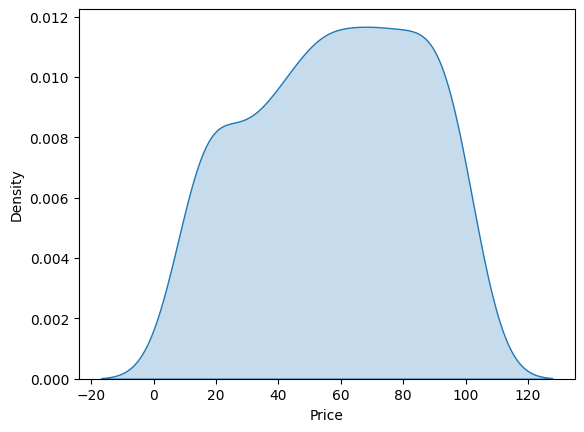

In [71]:
residuals=y_test-pred
sns.kdeplot(x=residuals, fill=True);

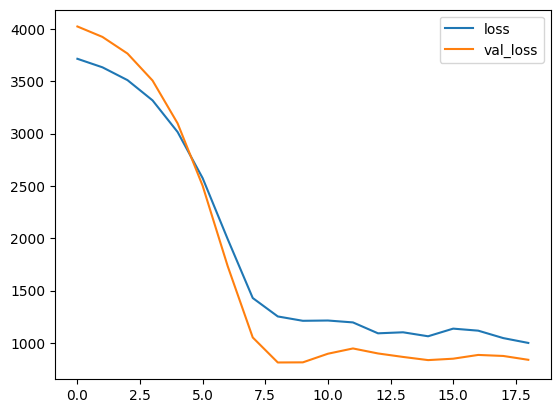

In [72]:
loss_f=pd.DataFrame(history.history)
loss_f.plot();

TR = R2_score ekşili değer aldığı için automl aynı sonuç verecek mi diye baktım.

EN = Since R2_score has a certain value, I checked whether automl would give the same result.

In [73]:
#pip install pycaret

In [74]:
#from pycaret.regression import*

In [75]:
#setup(df,target='Price')

In [76]:
#best_model=compare_models()